## Planting row detection with Hough Line Transform

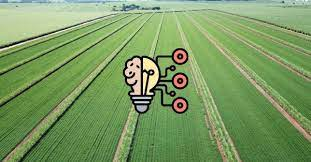

The Hough transform for line detection is a popular technique for identifying lines in images, including images taken by drones. The Hough transform converts points in the image to a parametric representation of lines, enabling line detection even in images with noise or discontinuities.

***Stages***

- Image preprocessing: Before applying the Hough transform, it is useful to perform some preprocessing steps on the image to improve the quality of the results. This may include applying filters to reduce noise, such as a smoothing filter (like a Gaussian filter) or an edge detection filter (like a Canny filter).

- Edge detection: The Hough transform operates on edges in the image, so it is necessary to apply an edge detection algorithm to the preprocessed image. The Canny algorithm is widely used for this purpose because it is effective at detecting edges and minimizes noise response.

- Applying the Hough transform: The Hough transform is applied to the edge image to identify the parameters (angle and distance) of the lines present in the image. The standard Hough transform operates in the angle and distance parameter space (or can be extended to detect lines with additional parameters, such as thickness).

- Line Thresholding and Detection: After applying the Hough Transform, you'll need to set a threshold to identify significant lines in the image. Points in the Hough Transform that exceed the threshold are considered representative of the detected lines. You can adjust the threshold to control the detection sensitivity.

- Draw the detected lines on the original image: Finally, based on the parameters of the lines detected in the previous step, you can draw the lines found on the original image. This will allow you to visualize the identified planting lines.

It's important to note that the Hough transform can be sensitive to different lighting conditions, textures, and other factors present in the images. Therefore, it may be necessary to adjust the Hough transform parameters and perform tests in different scenarios to obtain the best results.

Furthermore, consider that detecting crop rows in drone images can present specific challenges, such as the presence of vegetation, varying lighting conditions, and overlapping rows. Therefore, it may be necessary to explore additional techniques, such as image segmentation or custom filters, to address these situations and improve crop row detection accuracy.

Let's start by installing rasterio.

In [ ]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 99.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 15.8 MB/s eta 0:00:00


Now, let's connect Drive to access the files that will be used:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We will import the libraries that we are going to use

In [ ]:
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely
import math
import os
import rasterio
from rasterio.mask import mask
import json
from rasterio.plot import show
import matplotlib.pyplot as plt
import cv2
from skimage.morphology import skeletonize, convex_hull_image
from skimage.measure import label, regionprops
from shapely.geometry import shape
import shapely
from rasterio.features import shapes
from shapely.geometry import LineString

Link to dataset: https://drive.google.com/file/d/1BQs-sHg7YYyYRBqDEhJC0q52KjXPnSHb/view?usp=sharing

Then we set the path of the image we are going to use:

In [ ]:
path_img = '/content/drive/MyDrive/Datasets/Lines_planting/AOI_img.tif'

With rasterio we open the image and plot it with matplotlib:

In [ ]:
src = rasterio.open(path_img)

In [ ]:
img = src.read()

In [ ]:
img = img.transpose([1,2,0])

In [ ]:
img = img.astype('uint8')

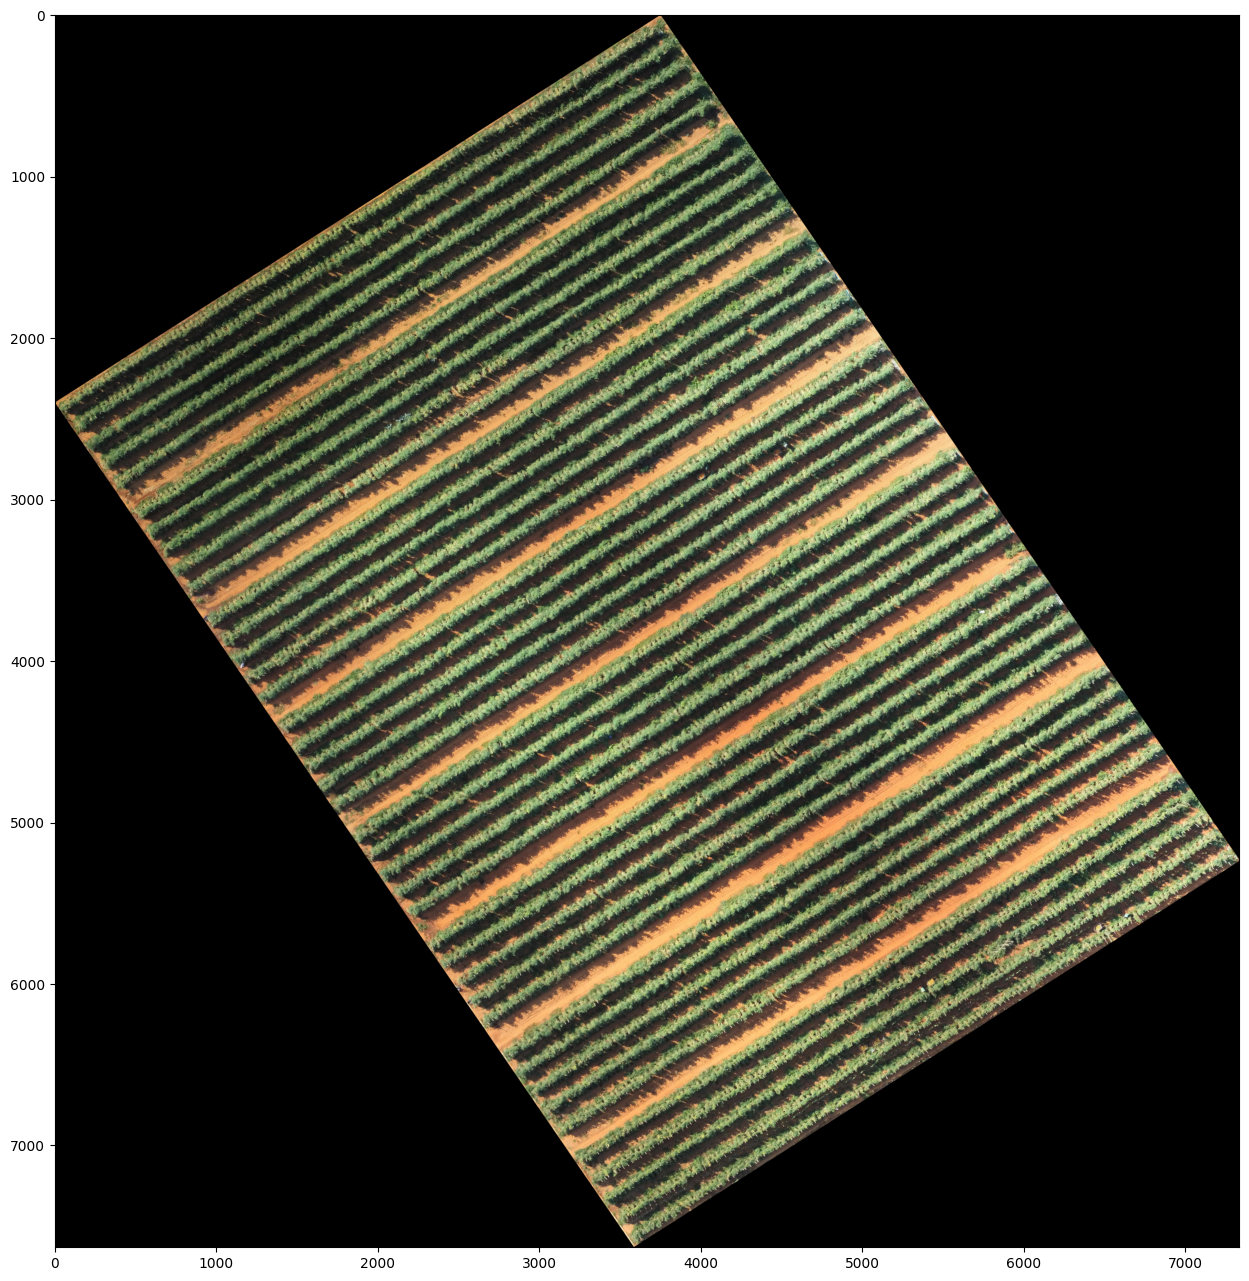

In [ ]:
plt.figure(figsize=[16,16])
plt.imshow(img)

In our RGB image we will separate the spectral bands and select the first spectral band.

In [ ]:
band = img[:,:,0]

(-0.5, 7335.5, 7630.5, -0.5)

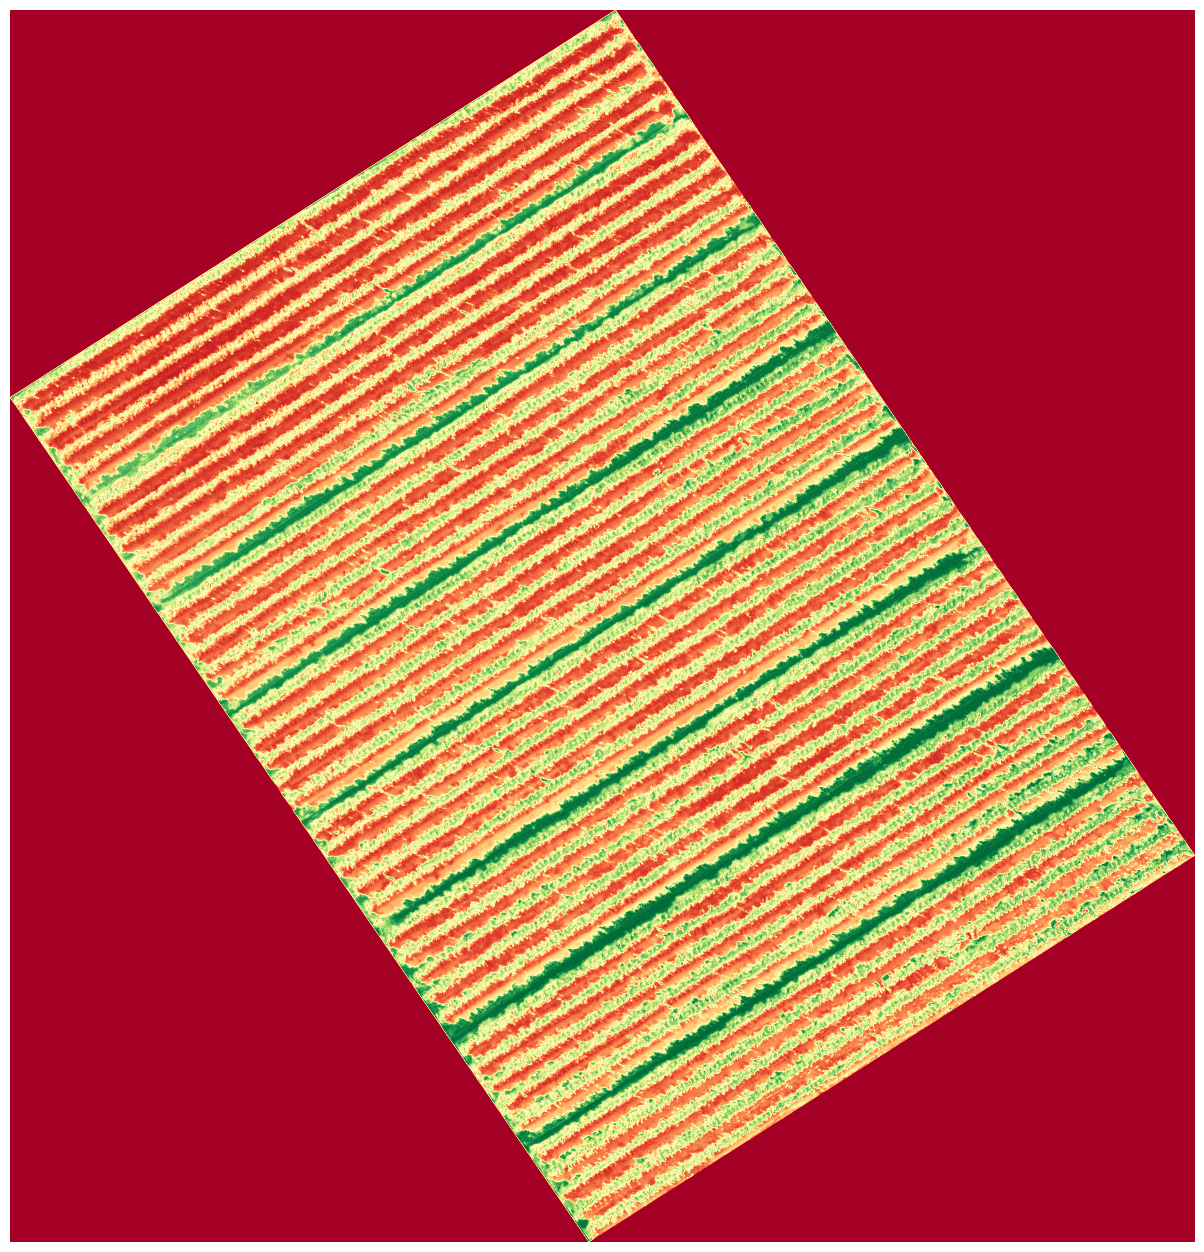

In [ ]:
plt.figure(figsize=[16,16])
plt.imshow(band,cmap='RdYlGn')
plt.axis('off')

Let's look at the histogram distribution of this band:

In [ ]:
pixels = img[:,:,0].ravel()
pixels = pixels[pixels != 0]

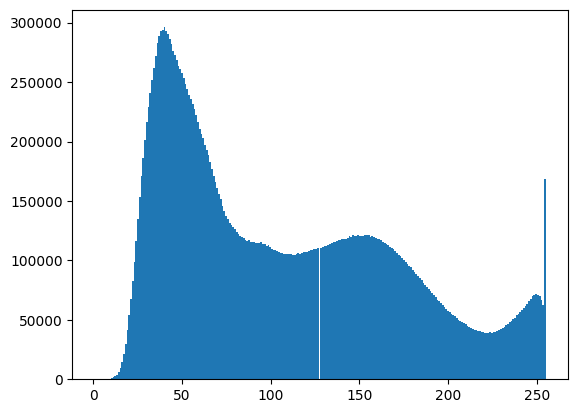

In [ ]:
ax = plt.hist(pixels, bins = 256)
plt.show()

In [ ]:
band  = img[:,:,0].copy()
band = np.where(band == 0 , 255, band)

We select a value to divide the distribution into two classes:

In [ ]:
_,thresh1 = cv2.threshold(band,90,1,cv2.THRESH_BINARY_INV)

In [ ]:
plt.figure(figsize=[16,16])
plt.imshow(thresh1, cmap='Greys_r')

Now let's get the bounding polygon of our region:

In [ ]:
hull = convex_hull_image(thresh1 == 1)

In [ ]:
plt.figure(figsize=[16,16])
plt.imshow(hull.astype('uint8'), cmap='Greys_r')

And convert the polygon image into a geodataframe that we will use later.

In [ ]:
shape_gen = ((shape(s), v) for s, v in shapes(hull.astype('uint8'), mask=hull, transform=src.transform))
Poly_gdf = gpd.GeoDataFrame(dict(zip(["geometry", "class"], zip(*shape_gen))), crs=src.crs)

Still with the polygon image, let's get the orientation of this polygon:

In [ ]:
for region in regionprops(hull.astype('uint8')):
  orientation = region.orientation
  angle_in_degrees = orientation * (180/np.pi)
  print(angle_in_degrees)

Then we will apply a rotation to the RGB image using the angle we obtain:

In [ ]:
rows,cols,_ = img.shape

In [ ]:
M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),-32,1)
dst_img = cv2.warpAffine(img,M,(cols,rows))

In [ ]:
plt.figure(figsize=[16,16])
plt.imshow(dst_img)
plt.axis('off')

We will also apply rotation to the binary image:

In [ ]:
rows,cols, = thresh1.shape

In [ ]:
M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),-32,1)
dst = cv2.warpAffine(thresh1,M,(cols,rows))

In [ ]:
plt.figure(figsize=[16,16])
plt.imshow(dst)
plt.axis('off')

Let's now apply the morphological elements of opening and dilation using rectangular kernels to filter the lines in the image:

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 25))
morph = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 5))
morph = cv2.morphologyEx(morph, cv2.MORPH_DILATE, kernel)

# use morphology open to remove thin lines from dotted lines
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10,3))
morph = cv2.erode(morph, kernel,  iterations = 5)

In [ ]:
plt.figure(figsize=[16,16])
plt.imshow(morph)
plt.axis('off')

We apply skeletonization to obtain fine lines:

In [ ]:
from skimage.morphology import skeletonize, convex_hull_image

In [ ]:
sk = skeletonize(morph == 1)

In [ ]:
plt.figure(figsize=[16,16])
plt.imshow(sk,cmap='gray')
plt.axis('off')

Since these lines have a lot of vertical noise, let's filter the image with a sobel in the horizontal direction:

In [ ]:
sobely = cv2.Sobel(morph.astype('uint8'),cv2.CV_8U,0,1,ksize=5)

In [ ]:
plt.figure(figsize=[16,16])
plt.imshow(sobely,cmap='gray')
plt.axis('off')

With this we can return the image to its original position.

In [ ]:
rows,cols,_ = img.shape

In [ ]:
M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),32,1)
result_img = cv2.warpAffine(sobely,M,(cols,rows))

In [ ]:
plt.figure(figsize=[16,16])
plt.imshow(result_img)
plt.axis('off')

We can use Hough Lines to identify planting lines:

In [ ]:
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line

In [ ]:
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)

h, theta, d = hough_line(result_img, theta=tested_angles)
hpeaks = hough_line_peaks(h, theta, d, threshold=0.50 * h.max())

In [ ]:
for _, angle, dist in zip(*hpeaks):
  print(dist)

Let's create a geodataframe of lines and plot them along with the RGB image:

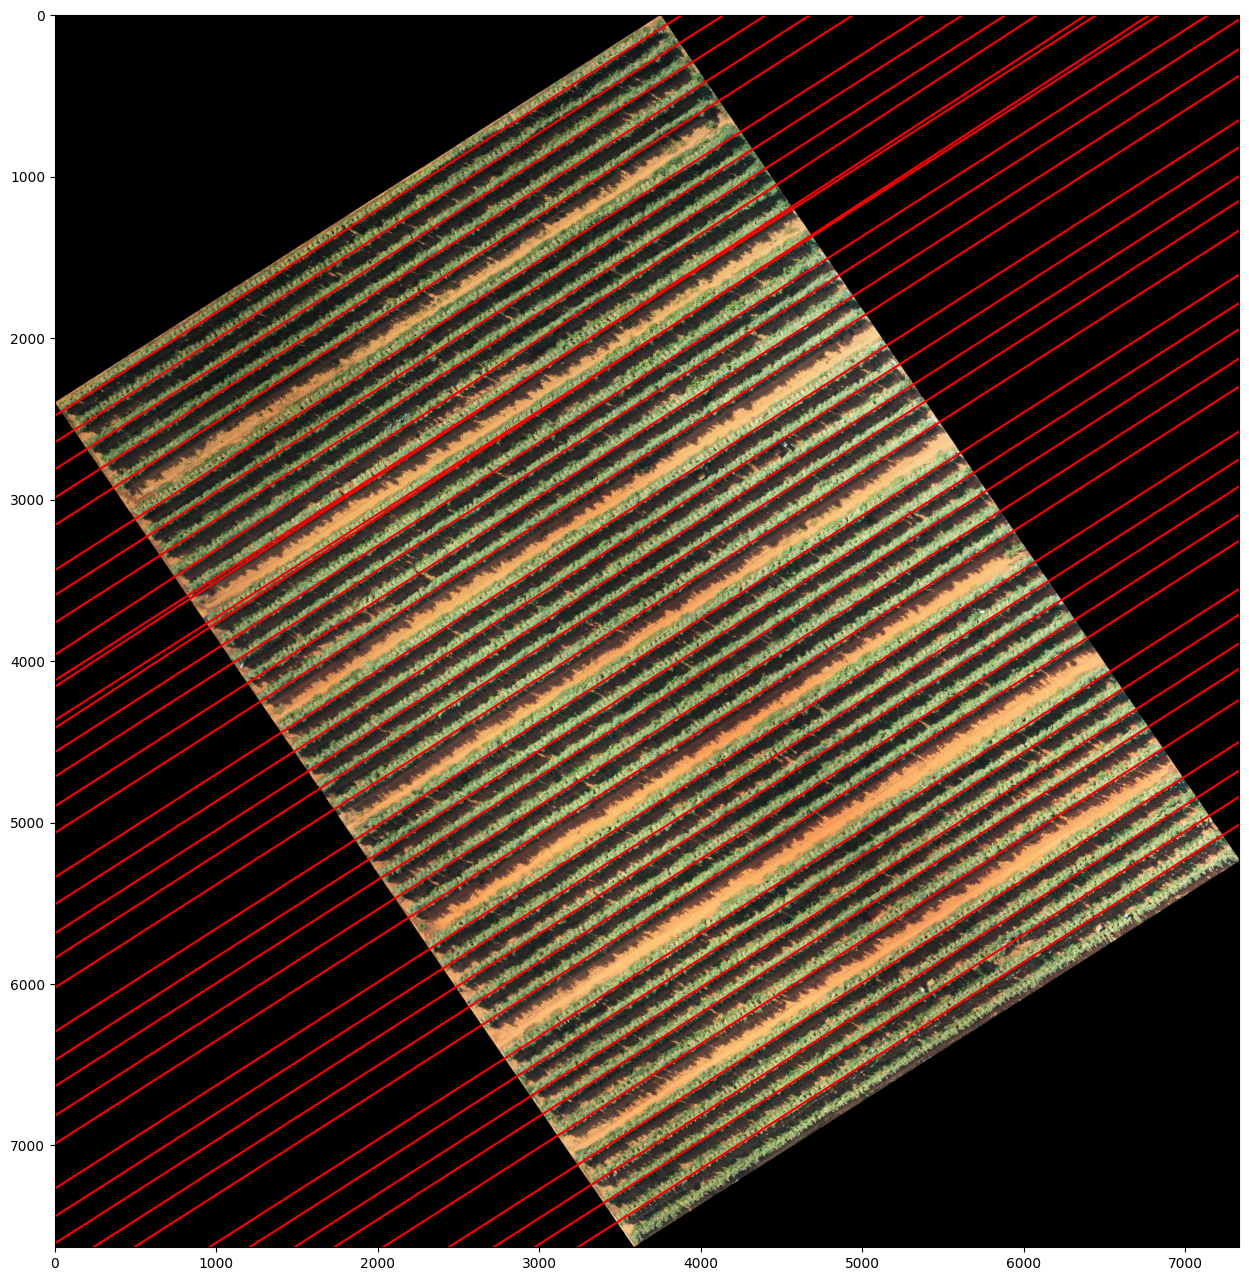

In [ ]:
plt.figure(figsize=(16,16))
plt.imshow(img)
i = 0
crs_target = src.crs.to_dict()['init']
gdf_full = gpd.GeoDataFrame([])
lines = []
lines_id = []
row1, col1, _ = img.shape
for _, angle, dist in zip(*hpeaks):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - col1 * np.cos(angle)) / np.sin(angle)
    pt1 = (0,int(y0))
    pt2 = (col1,int(y1))
    retval, pt1_result, pt2_result = cv2.clipLine((0,0,col1,row1), pt1, pt2)
    plt.plot((pt1_result[0], pt2_result[0]), (pt1_result[1], pt2_result[1]), '-r')

    coordinates_pt1 = rasterio.transform.xy(src.transform, pt1_result[1], pt1_result[0])
    coordinates_pt2 = rasterio.transform.xy(src.transform, pt2_result[1], pt2_result[0])

    coords = [coordinates_pt1,coordinates_pt2]
    line = LineString(coords)
    lines.append(line)
    lines_id.append(i)
    i = i+1
gdf = gpd.GeoDataFrame(data=lines_id,geometry=lines)
gdf = gdf.rename(columns={0:"Line_Id"})
gdf = gdf.set_crs(crs_target)
gdf_full = pd.concat([gdf_full,gdf])


When looking at the lines geodataframe, we saw that the lines go outside the valid area of the image:

<Axes: >

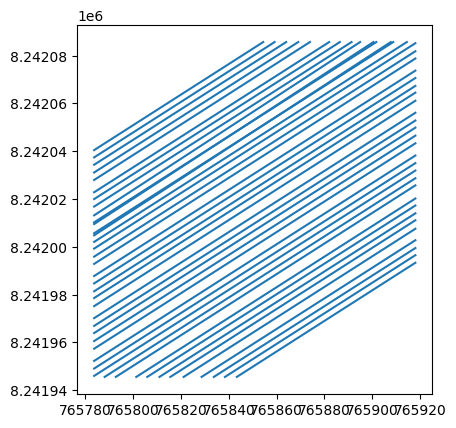

In [ ]:
gdf_full.plot()

Let's use the bounding polygon geodataframe to crop the parts of the lines that are not in the valid area of the image:

In [ ]:
Lines_cliped = gpd.overlay(gdf_full, Poly_gdf, how='intersection')

<Axes: >

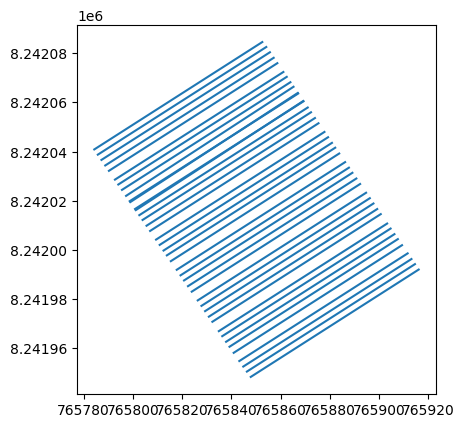

In [ ]:
Lines_cliped.plot()

Finally, we save it as a line shapefile:

In [ ]:
if not os.path.isdir('/content/shapefile'):
    os.mkdir('/content/shapefile')

In [ ]:
Lines_cliped.to_file("/content/shapefile/Lines.shp")

In [ ]:
!zip -r /content/shapefile.zip /content/shapefile
from google.colab import files
files.download("/content/shapefile.zip")

  adding: content/shapefile/ (stored 0%)
  adding: content/shapefile/Lines.shx (deflated 60%)
  adding: content/shapefile/Lines.prj (deflated 36%)
  adding: content/shapefile/Lines.shp (deflated 62%)
  adding: content/shapefile/Lines.cpg (stored 0%)
  adding: content/shapefile/Lines.dbf (deflated 91%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>